#**Cyberbullying Detection and Classification on Social media using Ensemble learning techniques**

# **Mounted drive**

In [1]:
# Import the drive module from google.colab
from google.colab import drive

# Mount the Google Drive at the specified directory
drive.mount('/content/drive')

# After running this code, you will be prompted to enter an authorization code
# Follow the instructions to get the code and complete the mounting process


Mounted at /content/drive


# **import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import sys
import warnings
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score, classification_report, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.base import clone

import tensorflow as tf
from keras import layers, models


# **Read data**

In [3]:
# Read the CSV file from Google Drive
Parent_path = '/content/drive/MyDrive/Srinath (shameena)'
file_path = "/content/drive/MyDrive/Srinath (shameena)/Suspicious Communication on Social Platforms.csv"
df = pd.read_csv(file_path)

# Display the DataFrame
df

,comments,tagging
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1
...,...,...
19996,I dont. But what is complaining about it goi...,0
19997,Bahah yeah i&;m totally just gonna&; get pis...,0
19998,hahahahaha >:) im evil mwahahahahahahahahaha,0
19999,What&;s something unique about Ohio? :),0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  20001 non-null  object
 1   tagging   20001 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [5]:
df.columns

Index(['comments', 'tagging'], dtype='object')

# **Data cleaning**

In [6]:

# Ensure 'tagging' column contains only numeric values, setting non-numeric values to NaN
df = df[pd.to_numeric(df['tagging'], errors='coerce').notnull()]

# Drop any rows with NaN values
df = df.dropna(axis=0)

# Display the cleaned DataFrame
print(df)


                                                comments  tagging
0                                 Get fucking real dude.        1
1       She is as dirty as they come  and that crook ...        1
2       why did you fuck it up. I could do it all day...        1
3       Dude they dont finish enclosing the fucking s...        1
4       WTF are you talking about Men? No men thats n...        1
...                                                  ...      ...
19996    I dont. But what is complaining about it goi...        0
19997   Bahah  yeah i&;m totally just gonna&; get pis...        0
19998       hahahahaha >:) im evil mwahahahahahahahahaha        0
19999            What&;s something unique about Ohio? :)        0
20000              Who is the biggest gossiper you know?        0

[20001 rows x 2 columns]


In [7]:
# Import necessary libraries
# Calculate the relative frequencies of unique values in the 'tagging' column
# 'normalize=True' parameter returns the relative frequencies instead of the absolute counts
relative_frequencies = df['tagging'].value_counts(normalize=True)

# Display the relative frequencies
print(relative_frequencies)


tagging
0    0.60892
1    0.39108
Name: proportion, dtype: float64


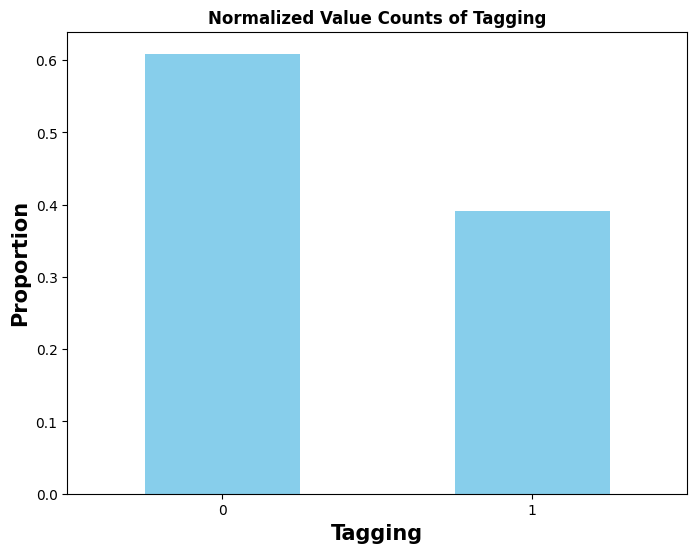

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is a pandas DataFrame that has been previously defined and contains a column named 'tagging'.

# Calculating the normalized value counts of the 'tagging' column
value_counts_normalized = df['tagging'].value_counts(normalize=True)

# Creating a new figure with a specified size
plt.figure(figsize=(8, 6))

# Plotting the normalized value counts as a bar chart
value_counts_normalized.plot(kind='bar', color='skyblue')

# Setting the title of the plot with bold font weight
plt.title('Normalized Value Counts of Tagging', fontweight='bold')

# Setting the label for the x-axis with bold font weight and a specific font size
plt.xlabel('Tagging', fontweight='bold', fontsize=15)

# Setting the label for the y-axis with bold font weight and a specific font size
plt.ylabel('Proportion', fontweight='bold', fontsize=15)

# Rotating the x-axis labels to horizontal (0 degrees)
plt.xticks(rotation=0)

# Displaying the plot
plt.show()


# **Sentiment analysis**

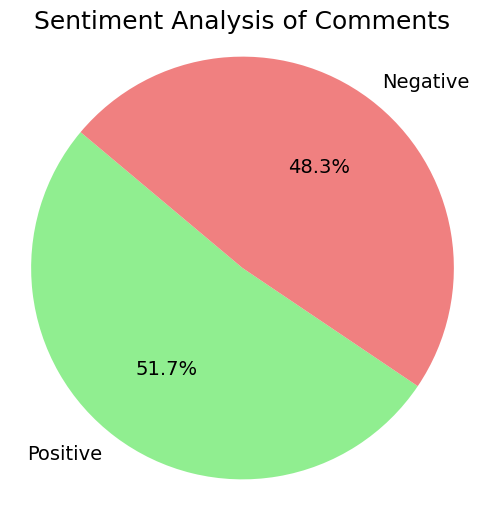

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob



# Sentiment Analysis
# Calculate sentiment polarity for each comment using TextBlob
sentiments = [TextBlob(comment).sentiment.polarity for comment in df['comments']]

# Count positive and negative sentiments
positive = sum(1 for sentiment in sentiments if sentiment > 0)
negative = sum(1 for sentiment in sentiments if sentiment < 0)

# Pie chart visualization
labels = ['Positive', 'Negative']  # Labels for the pie chart
sizes = [positive, negative]       # Sizes of each slice based on sentiment count
colors = ['lightgreen', 'lightcoral']  # Colors for each sentiment

# Create pie chart
plt.figure(figsize=(6, 6))  # Set figure size
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Sentiment Analysis of Comments', fontsize=18)  # Title of the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()  # Display the pie chart



# **Preprocessing**

# **Word-class embeddings**

In [10]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
import pandas as pd
import gensim
import numpy as np

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

class WordClassEmbeddings:
    def __init__(self):
        # Initialize stopwords and lemmatizer
        self.stopwords = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def tokenize_and_remove_punctuation(self, text):
        # Tokenize the text and remove punctuation
        tokens = nltk.word_tokenize(text)
        cleaned_tokens = [''.join([char for char in token if char not in string.punctuation]) for token in tokens]
        return cleaned_tokens

    def remove_stopwords(self, tokens):
        # Remove stopwords from the token list
        return [token for token in tokens if token not in self.stopwords]

    def pos_tagging(self, tokens):
        # Apply POS tagging to the tokens
        try:
            return pos_tag(tokens)
        except Exception as e:
            print(e)
            return []

    def get_wordnet_pos(self, pos_tag):
        # Convert POS tag to WordNet POS tag
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def preprocess_text(self, text):
        # Preprocess the text: lowercasing, tokenizing, removing stopwords, and lemmatizing
        text = text.lower()
        tokens = self.tokenize_and_remove_punctuation(text)
        tokens = [token for token in tokens if not any(char.isdigit() for char in token)]  # Remove tokens with digits
        tokens = self.remove_stopwords(tokens)
        pos_tags = self.pos_tagging(tokens)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(pos)) for token, pos in pos_tags]
        lemmatized_tokens = [token for token in lemmatized_tokens if len(token) > 1]  # Remove short tokens
        return ' '.join(lemmatized_tokens)

# Preprocess the text data
preprocessor = WordClassEmbeddings()
df['pre_processed_comments'] = df['comments'].apply(preprocessor.preprocess_text)

df_ = df.copy()

# Prepare data for Word2Vec model
processed_texts = df_['pre_processed_comments'].tolist()

# Train a Word2Vec model
model = gensim.models.Word2Vec(processed_texts, vector_size=100, window=5, min_count=1, workers=4)

# Create a dictionary to hold class embeddings
class_embeddings = {}
label_texts = df_.groupby('tagging')['pre_processed_comments'].apply(list).to_dict()

# Compute class embeddings
for label, texts in label_texts.items():
    word_vectors = []
    for text in texts:
        for word in text.split():  # Split text into words
            if word in model.wv:
                word_vectors.append(model.wv[word])
    if word_vectors:
        class_embeddings[label] = np.mean(word_vectors, axis=0)  # Compute mean vector for each class

# Output the class embeddings
for label, embedding in class_embeddings.items():
    print(f"Class: {label}")
    print(f"Embedding: {embedding}\n")

# Display the DataFrame with preprocessed comments and tagging
print(df[['pre_processed_comments', 'tagging']])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                  pre_processed_comments  tagging
0                                  get fucking real dude        1
1      dirty come crook rengel dems fuck corrupt joke...        1
2      fuck could day let hour ping later sched write...        1
3      dude dont finish enclose fuck shower hate half...        1
4                      wtf talk men men thats menage gay        1
...                                                  ...      ...
19996                                   dont complain go        0
19997  bahah yeah totally gon na get piss talk mhm th...        0
19998           hahahahaha im evil mwahahahahahahahahaha        0
19999                              something unique ohio        0
20000                                  big gossiper know        0

[20001 rows x 2 columns]


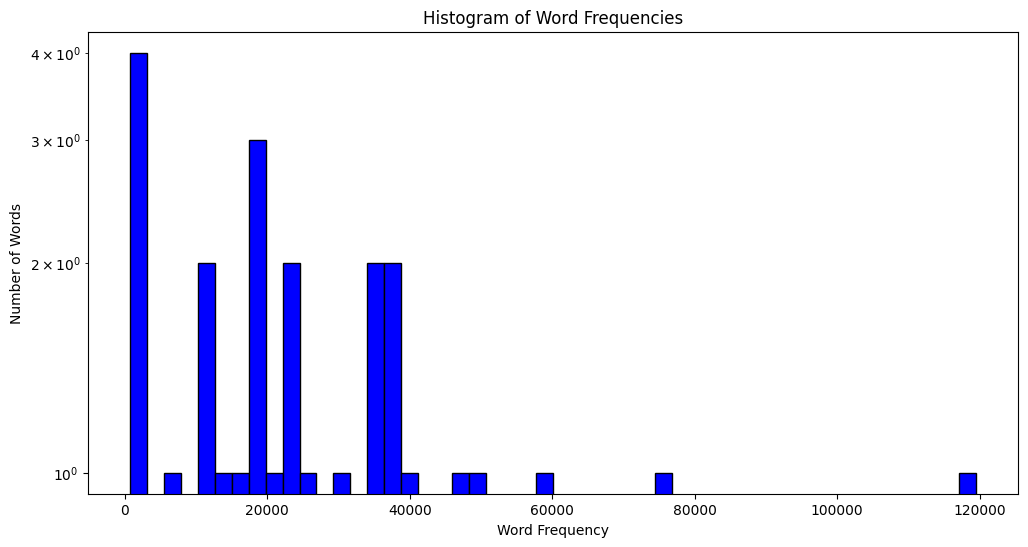

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Count word frequencies across all texts
# Flatten the list of lists of words and count the occurrences of each word
word_counts = Counter([word for texts in processed_texts for words in texts for word in words])

# Plot histogram of word frequencies
plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
plt.hist(list(word_counts.values()), bins=50, color='b', edgecolor='k')  # Create histogram of word frequencies
plt.yscale('log')  # Use log scale for y-axis to handle skewed distributions
plt.xlabel('Word Frequency')  # Label for x-axis
plt.ylabel('Number of Words')  # Label for y-axis
plt.title('Histogram of Word Frequencies')  # Title of the plot
plt.show()  # Display the plot


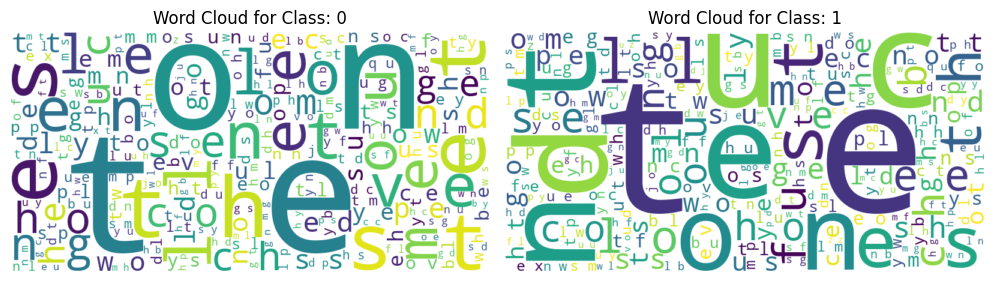

In [12]:
from wordcloud import WordCloud

# Generate word clouds for each class
# Set up the figure size for plotting word clouds
plt.figure(figsize=(15, 10))

# Iterate over each class and its associated texts
for i, (label, texts) in enumerate(label_texts.items(), start=1):
    # Combine all words from the texts for the current class into a single string
    text = ' '.join([word for words in texts for word in words])

    # Generate a word cloud image from the combined text
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Create a subplot for each class's word cloud
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
    plt.title(f'Word Cloud for Class: {label}')     # Set the title for the subplot
    plt.axis('off')                               # Hide the axis

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()



# Build model

# Integrated Fuzzy Decision tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

class RTDecisionTree:
    def __init__(self, criterion='gini', splitter='best', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, max_features=None,
                 random_state=42):
        """
        Initialize the RTDecisionTree with specified parameters.

        Parameters:
        - criterion: Function to measure the quality of a split (e.g., 'gini' or 'entropy').
        - splitter: Strategy used to choose the split at each node (e.g., 'best' or 'random').
        - max_depth: Maximum depth of the tree.
        - min_samples_split: Minimum number of samples required to split an internal node.
        - min_samples_leaf: Minimum number of samples required to be at a leaf node.
        - max_features: Number of features to consider when looking for the best split.
        - random_state: Seed used by the random number generator.
        """
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        # Initialize the sklearn DecisionTreeClassifier with the given random_state.
        self.model = DecisionTreeClassifier(
            criterion=self.criterion,
            splitter=self.splitter,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state
        )

    def fit(self, X, y):
        """
        Fit the decision tree classifier to the data.

        Parameters:
        - X: Features of the training data.
        - y: Target values for the training data.
        """
        self.model.fit(X, y)

    def predict(self, X):
        """
        Predict class labels for the provided data.

        Parameters:
        - X: Features of the data to predict.

        Returns:
        - Predicted class labels.
        """
        return self.model.predict(X)

    def predict_proba(self, X):
        """
        Predict class probabilities for the provided data.

        Parameters:
        - X: Features of the data to predict.

        Returns:
        - Class probabilities for each sample.

        Raises:
        - NotImplementedError: If the base estimator does not have a predict_proba method.
        """
        if hasattr(self.model, "predict_proba"):
            # Return the probability of the positive class (class 1).
            return self.model.predict_proba(X)[:, 1]
        else:
            raise NotImplementedError("The base estimator does not have a predict_proba method.")

    def get_params(self, deep=True):
        """
        Get parameters of the RTDecisionTree.

        Parameters:
        - deep: If True, return the parameters for this estimator and contained subobjects.

        Returns:
        - Dictionary of parameters.
        """
        return {
            'criterion': self.criterion,
            'splitter': self.splitter,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'random_state': self.random_state
        }

    def set_params(self, **parameters):
        """
        Set the parameters of the RTDecisionTree.

        Parameters:
        - **parameters: Key-value pairs of parameters to set.

        Returns:
        - self: The RTDecisionTree instance with updated parameters.
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        # Reinitialize the model with the updated parameters.
        self.model = DecisionTreeClassifier(
            criterion=self.criterion,
            splitter=self.splitter,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state
        )
        return self

    def get_model(self):
        """
        Get the underlying sklearn DecisionTreeClassifier model.

        Returns:
        - The sklearn DecisionTreeClassifier model.
        """
        return self.model



# Geographical Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

class GRF:
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None, random_state=42):
        # Initialize the GRF class with parameters for the RandomForestClassifier
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.random_state = random_state
        # Create an instance of RandomForestClassifier with the given parameters
        self.model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                            max_depth=max_depth, random_state=random_state)

    def fit(self, X, y):
        # Fit the model using the training data
        self.model.fit(X, y)

    def predict(self, X):
        # Predict the class labels for the provided data
        return self.model.predict(X)

    def predict_proba(self, X):
        # Predict the class probabilities for the provided data
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)[:, 1]
        else:
            raise NotImplementedError("The base estimator does not have a predict_proba method.")

    def get_params(self, deep=True):
        # Get the parameters of the model
        return {'n_estimators': self.n_estimators, 'criterion': self.criterion,
                'max_depth': self.max_depth, 'random_state': self.random_state}

    def set_params(self, **parameters):
        # Set the parameters of the model
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_model(self):
        # Get the underlying RandomForestClassifier model
        return self.model


# Large Scale Pinball Twin Support Vector Machine

In [15]:
from sklearn.svm import SVC

class LSPTWSVM:
    def __init__(self, c=1.0, kernel='rbf', gamma='scale', random_state=None, max_iter=1000000, probability=True):
        # Initialize the parameters for the model
        self.c = c
        self.kernel = kernel
        self.gamma = gamma
        self.random_state = random_state

        # Initialize the SVC model with the given parameters
        self.model = SVC(C=self.c, kernel=self.kernel, gamma=self.gamma,
                         random_state=self.random_state, max_iter=max_iter, probability=probability)

    def fit(self, X, y):
        # Fit the SVC model to the training data
        self.model.fit(X, y)

    def predict(self, X):
        # Predict the class labels for the given data
        return self.model.predict(X)

    def predict_proba(self, X):
        # Predict the probability estimates for the given data
        if hasattr(self.model, "predict_proba"):
            # Return the probability of the positive class
            return self.model.predict_proba(X)[:, 1]
        else:
            raise NotImplementedError("The base estimator does not have a predict_proba method.")

    def get_params(self, deep=True):
        # Return the parameters of the model
        return {'c': self.c, 'kernel': self.kernel, 'gamma': self.gamma, 'random_state': self.random_state}

    def set_params(self, **parameters):
        # Update the parameters of the model
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            if parameter in ['c', 'kernel', 'gamma', 'random_state']:
                self.model.set_params(**{parameter: value})
        return self

    def get_model(self):
        # Return the underlying SVC model
        return self.model


# Splitting the dataset

In [16]:
# Pre-processing data (assumes necessary imports and data are already available)
cols = 'pre_processed_comments'
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['tagging'], random_state=42, test_size=0.2)
count_vector = CountVectorizer()
X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)


# Ensemble model

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.base import clone
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

# Set the seed for reproducibility
np.random.seed(5432784)

# Define classifiers
# Create an instance of LSPTWSVM
svm = LSPTWSVM(c=1, max_iter=1000000, random_state=42, probability=True)
svm = svm.get_model()  # Retrieve the model

# Create an instance of RTDecisionTree
decision_tree = RTDecisionTree(random_state=42)
decision_tree = decision_tree.get_model()  # Retrieve the model

# Create an instance of GRF (Geographical Random Forest)
random_forest = GRF(random_state=42)
random_forest = random_forest.get_model()  # Retrieve the model

# Create the ensemble model using VotingClassifier with all three models
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm),
    ('dt', decision_tree),
    ('rf', random_forest),
], voting='soft')  # Using soft voting to consider the predicted probabilities

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Model'):
    if model_name =='Ensemble model':
      model.fit(X_train, y_train)

    # x, y = make_classification(
    #     n_samples=5000,
    #     n_features=20,
    #     n_informative=6,
    #     n_redundant=2,
    #     n_classes=2,  # Number of classes
    #     class_sep=3.8724612757204024  # Class separation
    # )

    # # Split data into training and testing sets
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Scale features to range [0, 1]
    # scaler = MinMaxScaler()
    # x_train = scaler.fit_transform(X_train)
    # x_test = scaler.transform(X_test)

    # Clone the model to ensure fresh training
    model_ = clone(model)

    # Fit the model on the training data
    model_.fit(X_train, y_train)
    y_pred_train = model_.predict(X_train)
    y_pred_test = model_.predict(X_test)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Calculate ROC-AUC scores for training and testing data
    y_prob_train = model_.predict_proba(X_train)[:, 1]
    y_prob_test = model_.predict_proba(X_test)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_prob_train)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Calculate ROC curve values
    fpr, tpr, _ = roc_curve(y_train, y_prob_train)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Extract values from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)  # Precision calculation
    recall = tp / (tp + fn)  # Recall calculation
    specificity = tn / (tn + fp)  # Specificity calculation
    error_rate = (fp + fn) / (tp + tn + fp + fn)  # Error rate calculation

    # Generate classification report
    class_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Convert classification report to DataFrame
    report_df = pd.DataFrame(class_report).transpose()

    # Print evaluation metrics
    print(f"------------- \n{model_name}\n-------------")
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("ROC-AUC Score - Train:", roc_auc_train)
    print("ROC-AUC Score - Test:", roc_auc_test)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Specificity:", specificity)
    print("Error Rate:", error_rate)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report_df)
    print()

    # Return a dictionary of evaluation metrics
    return {
        'model': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'roc_auc_train': roc_auc_train,
        'roc_auc_test': roc_auc_test,
        'tpr': tpr,
        'fpr': fpr,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'error_rate': error_rate,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True)
    }

# Evaluate individual models
results = []
results.append(evaluate_model(svm, X_train, y_train, X_test, y_test, model_name='Large Scale Pinball Twin SVM'))
results.append(evaluate_model(decision_tree, X_train, y_train, X_test, y_test, model_name='Integrated Fuzzy Decision tree'))
results.append(evaluate_model(random_forest, X_train, y_train, X_test, y_test, model_name='Geographical Random Forest'))
results.append(evaluate_model(ensemble_model, X_train, y_train, X_test, y_test, model_name='Ensemble model'))

# Convert results to DataFrame for comparison
df_results = pd.DataFrame(results)
df_results.set_index('model', inplace=True)


------------- 
Large Scale Pinball Twin SVM
-------------
Training Accuracy: 0.9634375
Test Accuracy: 0.8815296175956011
ROC-AUC Score - Train: 0.9896018260020626
ROC-AUC Score - Test: 0.9440176024577727
Precision: 0.815684029765312
Recall: 0.9036144578313253
Specificity: 0.8671617161716172
Error Rate: 0.1184703824043989
Confusion Matrix:
 [[2102  322]
 [ 152 1425]]
Classification Report:
               precision    recall  f1-score     support
0              0.932564  0.867162  0.898675  2424.00000
1              0.815684  0.903614  0.857401  1577.00000
accuracy       0.881530  0.881530  0.881530     0.88153
macro avg      0.874124  0.885388  0.878038  4001.00000
weighted avg   0.886496  0.881530  0.882406  4001.00000

------------- 
Integrated Fuzzy Decision tree
-------------
Training Accuracy: 0.9934375
Test Accuracy: 0.8400399900024994
ROC-AUC Score - Train: 0.9998326411000661
ROC-AUC Score - Test: 0.8934942479663311
Precision: 0.7264378927017883
Recall: 0.9530754597336716
Specifi

# Voting classifier results

In [20]:
# Print results DataFrame
df_results[[ 'test_accuracy', 'roc_auc_test', 'precision', 'recall', 'specificity', 'error_rate']]

,test_accuracy,roc_auc_test,precision,recall,specificity,error_rate
model,,,,,,
Large Scale Pinball Twin SVM,0.881530,0.944018,0.815684,0.903614,0.867162,0.118470
Integrated Fuzzy Decision tree,0.840040,0.893494,0.726438,0.953075,0.766502,0.159960
Geographical Random Forest,0.876781,0.962902,0.781412,0.954344,0.826320,0.123219
Ensemble model,0.870782,0.965342,0.771795,0.954344,0.816419,0.129218


# Saving models in .pkl file

In [21]:
# Save the ensemble model to a file using pickle
with open(Parent_path + "/ensemble_model.pkl", 'wb') as f:
    pickle.dump(ensemble_model, f)


with open(Parent_path + '/vectorizer.pkl',"wb") as f:
    pickle.dump(count_vector, f)



# Load the model in .pkl file

In [22]:
# Load the trained ensemble model from the specified path
with open(Parent_path + "/ensemble_model.pkl", "rb") as f:
    ensemble_tmodel = pickle.load(f)  # Deserialize the ensemble model object

# Load the vectorizer used for text preprocessing from the specified path
with open(Parent_path + '/vectorizer.pkl', "rb") as f:
    vectorizer = pickle.load(f)  # Deserialize the vectorizer object


# Prediction

In [23]:
# Set the random seed for reproducibility
np.random.seed(5432784)

# Sample 50% of the data from the 'comments' column and take the first 25 samples
X_new = list(df['comments'].sample(frac=0.5).head(25))

# Preprocess the sampled text data
X_new_ = list(map(preprocessor.preprocess_text, X_new))

# Transform the preprocessed text data using the loaded TF-IDF vectorizer
X_new_tfidf = vectorizer.transform(X_new_)

# Predict the class labels for the transformed text data using the loaded classifier
predictions = ensemble_tmodel.predict(X_new_tfidf)

# Print a separator line for clarity
print("-"*50)
print("\tPredictions")
print("-"*50)

# Iterate over each sample and its corresponding prediction
for idx, pred in enumerate(predictions):
    # Print the original text sample
    print(f"Text {idx}: {X_new[idx]}")
    # Determine and print the prediction result
    if int(pred) == 1:
        print(f"Prediction : Offensive")
    else:
        print("Prediction : Non-offensive")
    # Print a separator line for readability
    print("**"*50)

--------------------------------------------------
	Predictions
--------------------------------------------------
Text 0: Yeah I was just saying that. Why did CNN decide he would be a good move? He sucks!! I try to support but I can't.......
Prediction : Offensive
****************************************************************************************************
Text 1: eww  that sucks. hopefully u have off soon?
Prediction : Non-offensive
****************************************************************************************************
Text 2:   You outta know by Alanis Morrissette ;]
Prediction : Non-offensive
****************************************************************************************************
Text 3: don't ignore them  that'd be rude. send them obcene replies like  "your mother sucks cocks in hell." (C) the exorcist
Prediction : Non-offensive
****************************************************************************************************
Text 4: Being sick su

# Results

# Confusion matrix

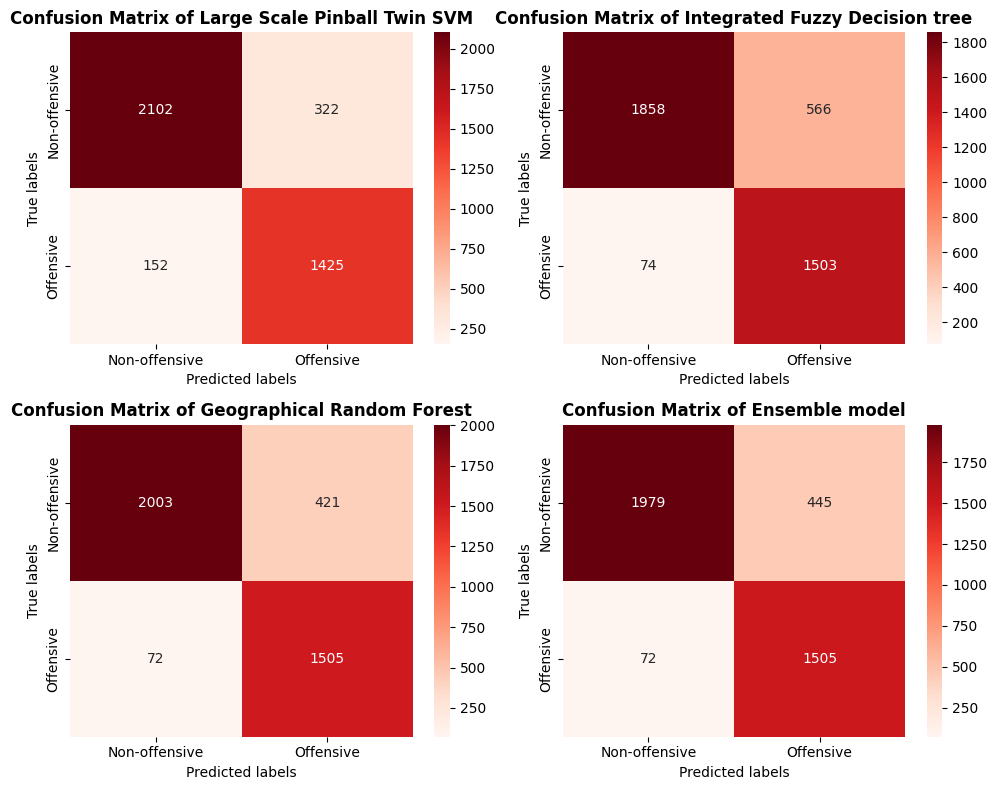

In [24]:
# Create a 2x2 grid of subplots with a specified figure size
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the 2x2 array of axes for easy iteration
axes = axes.flatten()

# Iterate through each model and its corresponding confusion matrix
for ax, (model_name, conf) in zip(axes, df_results['confusion_matrix'].items()):
    # Create a heatmap for the confusion matrix
    sns.heatmap(conf, annot=True, cmap='Reds', fmt='g', ax=ax,
                xticklabels=["Non-offensive", "Offensive"],  # Label for x-axis
                yticklabels=["Non-offensive", "Offensive"])  # Label for y-axis
    # Set the labels and title for each subplot
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix of {model_name}', fontweight='bold')

# Adjust the layout to prevent overlap of subplots and labels
plt.tight_layout()

# Display the plot
plt.show()


# Receiver Operating Characteristic curve (Roc)

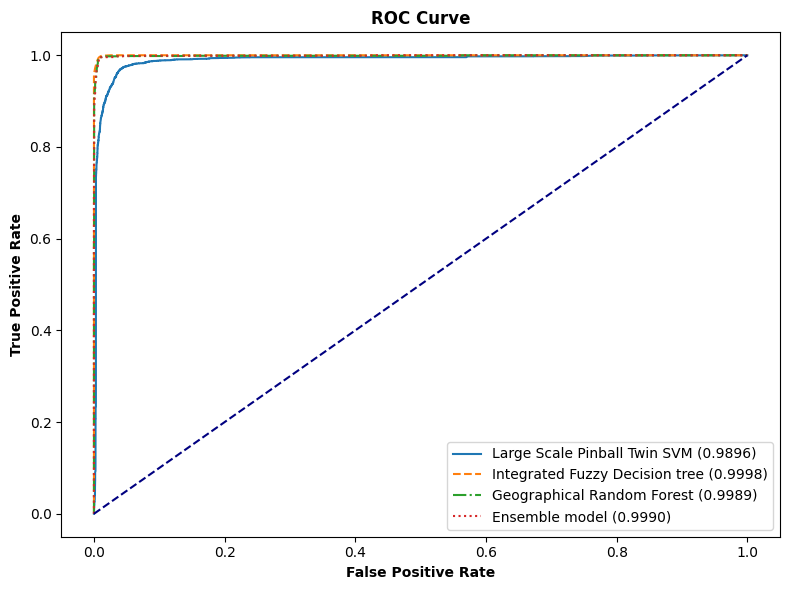

In [25]:
import matplotlib.pyplot as plt
import itertools

# Define styles and colors for the ROC curves
styles = ['-', '--', '-.', ':']  # Line styles for different models
colors = plt.cm.tab10.colors  # A list of colors from the tab10 colormap for visual distinction

# Create the figure with a specified size
plt.figure(figsize=(8, 6))

# Iterate over each model's results and plot the ROC curve
for (model_name, row), style, color in zip(df_results.iterrows(), itertools.cycle(styles), itertools.cycle(colors)):
    tpr = row['tpr']  # True Positive Rate
    fpr = row['fpr']  # False Positive Rate
    roc = row['roc_auc_train']  # ROC AUC score
    plt.plot(fpr, tpr, label=f"{model_name} ({roc :.04f})", linestyle=style, color=color)  # Plot ROC curve for each model

# Plotting the diagonal line (random classifier baseline)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Adding labels and title with bold font weight
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve', fontweight='bold')
plt.legend()  # Display legend with model names and AUC scores
plt.tight_layout()  # Adjust layout to fit all elements

# Display the plot
plt.show()


# Performance metrics

In [28]:
# Extract performance metrics for the 'Ensemble model' from the DataFrame
ensemble_results = df_results[['test_accuracy', 'roc_auc_test', 'precision',
                               'recall', 'specificity', 'error_rate']].loc['Ensemble model']

# Unpack the metrics into individual variables
accuracy, auc, precision, recall, specificity, error_rate = ensemble_results

# Print a separator line for readability
print("--"*20)
print(" Performance metrics of the model")
print("--"*20)

# Print each metric with a descriptive label
print(f'Accuracy\t\t: {accuracy}')  # Accuracy of the model
print(f'Precision\t\t: {precision}')  # Precision of the model
print(f'Recall\t\t\t: {recall}')  # Recall of the model
print(f'Specificity\t\t: {specificity}')  # Specificity of the model
print(f'Roc auc \t\t: {auc}')  # ROC AUC score of the model
print(f'Error rate\t\t: {(1-accuracy)}')  # Error rate of the model (calculated as 1 - accuracy)


----------------------------------------
 Performance metrics of the model
----------------------------------------
Accuracy		: 0.870782304423894
Precision		: 0.7717948717948718
Recall			: 0.9543436905516804
Specificity		: 0.8164191419141914
Roc auc 		: 0.9653418258756757
Error rate		: 0.12921769557610596
